### After several days of getting my scraper to a reasonable level, now it's time to build a simple model that describes the data 

### Current
since I lack time-series data for each location this will simply use know information as well as maybe some exogeneous information to predict prices.

- determine what predictors are releavent on a national level to estimate prices
- determine what predictors are releavent on a local level to restimate prices

### FUTURE
forecast prices

- locate additional sources of information to be used for backtests
- seasonality model?



In [1]:
### import the relevant libraries ###
import pandas as pd
import numpy as np
from datetime import datetime as dt
pd.options.display.float_format = "{:.0f}".format
pd.pandas.set_option('display.max_columns',None)

import re
import time

#### sklearn ###
from sklearn.preprocessing import StandardScaler
retail_scaler = StandardScaler()

# for making a Custom Scaler
from sklearn.base import BaseEstimator, TransformerMixin

# import the LogReg model from sklearn
from sklearn.linear_model import LogisticRegression

# import the 'metrics' module, which includes important metrics we may want to use
from sklearn import metrics

In [2]:
# create the Custom Scaler class

class CustomScaler(BaseEstimator,TransformerMixin): 
    
    # init or what information we need to declare a CustomScaler object
    # and what is calculated/declared as we do
    
    def __init__(self,columns,copy=True,with_mean=True,with_std=True):
        
        # scaler is nothing but a Standard Scaler object
        self.scaler = StandardScaler(copy,with_mean,with_std)
        # with some columns 'twist'
        self.columns = columns
        self.mean_ = None
        self.var_ = None
        
    
    # the fit method, which, again based on StandardScale
    
    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns], y)
        self.mean_ = np.mean(X[self.columns])
        self.var_ = np.var(X[self.columns])
        return self
    
    # the transform method which does the actual scaling

    def transform(self, X, y=None, copy=None):
        
        # record the initial order of the columns
        init_col_order = X.columns
        
        # scale all features that you chose when creating the instance of the class
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns)
        
        # declare a variable containing all information that was not scaled
        X_not_scaled = X.loc[:,~X.columns.isin(self.columns)]
        
        # return a data frame which contains all scaled features and all 'not scaled' features
        # use the original order (that you recorded in the beginning)
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]

In [3]:
unfiltered_data = pd.read_csv("DATA/scrape_files/Master.csv")
unfiltered_data.shape


(34959, 15)

In [4]:
unfiltered_data[unfiltered_data.sqft.str.contains("-") | unfiltered_data.sqft.str.contains("NaN")].count()


Unnamed: 0     2147
name           2147
address        2147
unit           2147
sqft           2147
bed            2147
bath           2147
price          2147
city           2147
state          2147
zipcode        2147
description    2147
details        2147
url            2147
date           2147
dtype: int64

In [5]:
unfiltered_data[~unfiltered_data.sqft.str.contains("-", na=False)].count()

Unnamed: 0     32812
name           32812
address        32812
unit           32070
sqft           32066
bed            32812
bath           32812
price          32812
city           32812
state          32812
zipcode        32812
description    32812
details        32812
url            32812
date           32812
dtype: int64

In [6]:
# remove the 2k+ appartment summary listsings, which (I believe moves the data where the column was shifted)
uf_data = unfiltered_data[~unfiltered_data.sqft.str.contains("-", na=False)]
uf_data = uf_data[~uf_data.unit.str.contains("Bed", na=False)]
uf_data = uf_data[uf_data.unit != 'home'] # get rid of homes/condos for rent (for now)

In [7]:
uf_data.sqft.replace(regex=True, to_replace=r'\D', value='', inplace=True)
uf_data.sqft.fillna(0, inplace=True)

uf_data.unit.replace(regex=True, to_replace=r'\D', value='', inplace=True)
uf_data.bed.replace(regex=True, to_replace=r'\D', value='', inplace=True)
uf_data.bath.replace(regex=True, to_replace=r'\D', value='', inplace=True)
uf_data.price.replace(regex=True, to_replace=r'\D', value='', inplace=True)

In [8]:
uf_data.price.replace(regex=True, to_replace=r'\D', value='', inplace=True)

In [9]:
def detail_string_to_dict_iter(detail):
    """ Converts details section to a dictionary using iterators and zipping
    TEST: comparision with simple list assignments
    Retult: List assignment faster by almost 2x..."""

    my_dict = {}

    for d in detail.split(','):
        if ":" in d:
            it = iter([(d.split(":")[0]).strip(), (d.split(":")[1]).strip()])
            mydict = dict(zip(it, it))
            my_dict.update(mydict)

        else:
            it = iter((d.strip()+":True").split(":"))
            myd = dict(zip(it, it))
            # print(myd)
            my_dict.update(myd)

    return my_dict

def detail_string_to_dict(detail):
    """ Converts details section to a dictionary using list assignment
    TEST: comparision with simple list assignments
    Retult: List assignment faster by almost 2x...
    Renaming this function to the main one. Moving on."""

    my_dict_list = {}
    for d in detail.split(','):
        if ":" in d:
            # Using lists
            my_dict_list.update({d.split(":")[0]: d.split(":")[1]})
        else:
            my_dict_list.update({(d.strip()+":True").split(":")[0]: (d.strip()+":True").split(":")[1]})
    return my_dict_list

In [10]:
iter_df = pd.DataFrame()
start_time = time.time()
iter_df['details'] = uf_data.details.apply(detail_string_to_dict_iter)
end_time = time.time()
print(end_time - start_time)

0.33043861389160156


In [11]:
list_df = pd.DataFrame()
start_time = time.time()
list_df['details'] = uf_data.details.apply(detail_string_to_dict)
end_time = time.time()
print(end_time - start_time)

0.2899332046508789


In [12]:
uf_data['details'] = uf_data.details.apply(detail_string_to_dict)

In [13]:
uf_data.head()

,Unnamed: 0,name,address,unit,sqft,bed,bath,price,city,state,zipcode,description,details,url,date
1,1,Avanti Apartments,10697 W Centennial Pkwy,2140,753,1,1,1127,Las Vegas,NV,89166,This apartment is located at 10697 W Centennia...,"{'Heating': ' Other ', 'Days on Market': ' 41 ...",https://www.trulia.com/c/nv/las-vegas/avanti-a...,11/17/2020
2,2,Avanti Apartments,10697 W Centennial Pkwy,1119,771,1,1,1124,Las Vegas,NV,89166,This apartment is located at 10697 W Centennia...,"{'Heating': ' Other ', 'Days on Market': ' 41 ...",https://www.trulia.com/c/nv/las-vegas/avanti-a...,11/17/2020
3,3,Avanti Apartments,10697 W Centennial Pkwy,1078,849,1,1,1335,Las Vegas,NV,89166,This apartment is located at 10697 W Centennia...,"{'Heating': ' Other ', 'Days on Market': ' 41 ...",https://www.trulia.com/c/nv/las-vegas/avanti-a...,11/17/2020
4,4,Avanti Apartments,10697 W Centennial Pkwy,1092,820,1,1,1347,Las Vegas,NV,89166,This apartment is located at 10697 W Centennia...,"{'Heating': ' Other ', 'Days on Market': ' 41 ...",https://www.trulia.com/c/nv/las-vegas/avanti-a...,11/17/2020
5,5,Avanti Apartments,10697 W Centennial Pkwy,3030,801,1,1,1123,Las Vegas,NV,89166,This apartment is located at 10697 W Centennia...,"{'Heating': ' Other ', 'Days on Market': ' 41 ...",https://www.trulia.com/c/nv/las-vegas/avanti-a...,11/17/2020


In [14]:
deets = uf_data.details
deets.head()

1    {'Heating': ' Other ', 'Days on Market': ' 41 ...
2    {'Heating': ' Other ', 'Days on Market': ' 41 ...
3    {'Heating': ' Other ', 'Days on Market': ' 41 ...
4    {'Heating': ' Other ', 'Days on Market': ' 41 ...
5    {'Heating': ' Other ', 'Days on Market': ' 41 ...
Name: details, dtype: object

In [15]:
# generate a list off all possible details
my_list = []
for deet in deets:
    # print(deet)
    for d in deet:
        if d not in my_list:
            my_list.append(d)
        else:
            pass

    # my_list.append(list(deet.keys()))
my_list

['Heating',
 'Days on Market',
 'Year Built',
 'Property Type',
 'Microwave',
 'Air Conditioning',
 'Hot Tub or Spa',
 'Balcony',
 'Parking',
 'Pool',
 'Cats',
 'dogs allowed',
 'Fitness Center',
 'Additional Storage',
 'Dishwasher',
 'Disposal',
 'Dryer',
 'Laundry Facilities',
 'Washer',
 'Window Coverings',
 'Disabled Access',
 'Gated Entry',
 'Patio',
 'Assigned Parking Space',
 'Ceiling Fan',
 'Garage',
 'Refrigerator',
 'Barbeque Area',
 'Garden',
 'Sprinkler System',
 'Off Street',
 'Security System',
 'Views',
 'Fireplace',
 'Deck',
 'Sauna',
 'Electric',
 'HOA Fee',
 'Lawn',
 'Other',
 'Elevator',
 'Basketball Court',
 'Tennis Court',
 'Garage Detached',
 'Lot Size',
 'Furnished',
 'Gas',
 'Vaulted Ceiling',
 'Cats allowed',
 'Sport Court',
 'Skylight',
 'Double Paned Windows',
 'Intercom',
 'Handrails',
 'On Street',
 'Dogs allowed',
 'See Virtual Tour',
 'Propane Butane',
 'Wet Bar',
 'Dock',
 'Waterfront',
 'None',
 'Porch',
 'Pond',
 'Solar',
 'Doorman',
 'Forced Air',
 'R

In [16]:
# Columns to keep
keepers = ["price", "sqft", "bed", "bath", "zipcode", "details"]
keep_df = uf_data[keepers]
keep_df.head(1)

,price,sqft,bed,bath,zipcode,details
1,1127,753,1,1,89166,"{'Heating': ' Other ', 'Days on Market': ' 41 ..."


In [17]:
details_list = ['Heating',
 'Days on Market',
 'Year Built',
 'Property Type',
 'Microwave',
 'Air Conditioning',
 'Hot Tub or Spa',
 'Balcony',
 'Parking',
 'Pool',
 'Cats',
 'dogs allowed',
 'Fitness Center',
 'Additional Storage',
 'Dishwasher',
 'Disposal',
 'Dryer',
 'Laundry Facilities',
 'Washer',
 'Window Coverings',
 'Disabled Access',
 'Gated Entry',
 'Patio',
 'Assigned Parking Space',
 'Ceiling Fan',
 'Garage',
 'Refrigerator',
 'Barbeque Area',
 'Garden',
 'Sprinkler System',
 'Off Street',
 'Security System',
 'Views',
 'Fireplace',
 'Deck',
 'Sauna',
 'Electric',
 'HOA Fee',
 'Lawn',
 'Other',
 'Elevator',
 'Basketball Court',
 'Tennis Court',
 'Garage Detached',
 'Lot Size',
 'Furnished',
 'Gas',
 'Vaulted Ceiling',
 'Cats allowed',
 'Sport Court',
 'Skylight',
 'Double Paned Windows',
 'Intercom',
 'Handrails',
 'On Street',
 'Dogs allowed',
 'See Virtual Tour',
 'Propane Butane',
 'Wet Bar',
 'Dock',
 'Waterfront',
 'None',
 'Porch',
 'Pond',
 'Solar',
 'Doorman',
 'Forced Air',
 'Rv Parking']

In [18]:
all_features_df = pd.concat([keep_df, pd.DataFrame(columns=details_list)])
all_features_df.head(1)

,price,sqft,bed,bath,zipcode,details,Heating,Days on Market,Year Built,Property Type,Microwave,Air Conditioning,Hot Tub or Spa,Balcony,Parking,Pool,Cats,dogs allowed,Fitness Center,Additional Storage,Dishwasher,Disposal,Dryer,Laundry Facilities,Washer,Window Coverings,Disabled Access,Gated Entry,Patio,Assigned Parking Space,Ceiling Fan,Garage,Refrigerator,Barbeque Area,Garden,Sprinkler System,Off Street,Security System,Views,Fireplace,Deck,Sauna,Electric,HOA Fee,Lawn,Other,Elevator,Basketball Court,Tennis Court,Garage Detached,Lot Size,Furnished,Gas,Vaulted Ceiling,Cats allowed,Sport Court,Skylight,Double Paned Windows,Intercom,Handrails,On Street,Dogs allowed,See Virtual Tour,Propane Butane,Wet Bar,Dock,Waterfront,None,Porch,Pond,Solar,Doorman,Forced Air,Rv Parking
1,1127,753,1,1,89166,"{'Heating': ' Other ', 'Days on Market': ' 41 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
test_df = pd.DataFrame(columns=details_list)
for row in range(1, len(all_features_df.details[:10])):
    # print(pd.DataFrame([all_features_df.details[row]], index=[row]))
    # single[row] = 
    pd.DataFrame([all_features_df.details[row]], index=[row])
    # test_df.merge(single, on=index)
    # test_df[feature] = all_features_df.details[1][feature].strip()
    # test_df[feature] = feature.valuetest_df
# single.dtypes
# test_df

In [20]:
final = pd.DataFrame.from_dict(all_features_df.details.to_dict())
final = final.T
final.tail()

,Heating,Days on Market,Year Built,Property Type,Microwave,Air Conditioning,Hot Tub or Spa,Balcony,Parking,Pool,Cats,dogs allowed,Fitness Center,Additional Storage,Dishwasher,Disposal,Dryer,Laundry Facilities,Washer,Window Coverings,Disabled Access,Gated Entry,Patio,Assigned Parking Space,Ceiling Fan,Garage,Refrigerator,Barbeque Area,Garden,Sprinkler System,Off Street,Security System,Views,Fireplace,Deck,Sauna,Electric,HOA Fee,Lawn,Other,Elevator,Basketball Court,Tennis Court,Garage Detached,Lot Size,Furnished,Gas,Vaulted Ceiling,Cats allowed,Sport Court,Skylight,Double Paned Windows,Intercom,Handrails,On Street,Dogs allowed,See Virtual Tour,Propane Butane,Wet Bar,Dock,Waterfront,None,Porch,Pond,Solar,Doorman,Forced Air,Rv Parking
34951,Forced Air,16 Days on Trulia,1972,Apartment,True,NaN,NaN,NaN,None,NaN,True,True,NaN,NaN,True,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34953,Forced Air,48 Days on Trulia,1963,Apartment,NaN,NaN,NaN,NaN,None,True,True,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34954,Forced Air,48 Days on Trulia,1963,Apartment,NaN,NaN,NaN,NaN,None,True,True,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34956,NaN,NaN,NaN,Apartment,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34958,NaN,20 Days on Trulia,NaN,Apartment,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
final = pd.DataFrame(final)

In [22]:
final = final.merge(keep_df, left_index=True, right_index=True)

In [23]:
# format integer features
final.price = final.price.astype(int)
final.sqft = final.sqft.astype(int)
final.bath = final.bath.astype(int)
final.bed[final.bed == ''] = 0
final.bed = final.bed.astype(int)
final.zipcode = final.zipcode.astype(int)


In [24]:
final = final[(final.price < 10000)]
final = final[(final.price > 0)]
final = final[final.sqft > 0]

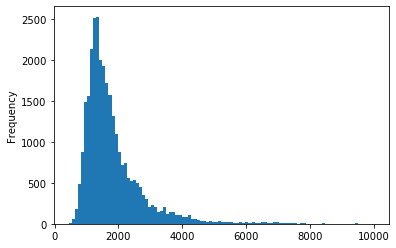

In [25]:
final.price.plot.hist(bins=100)

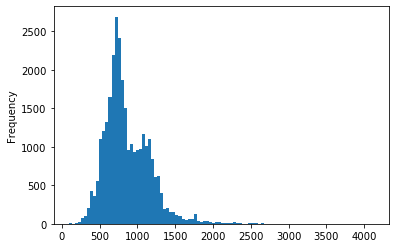

In [26]:
final.sqft.plot.hist(bins=100)

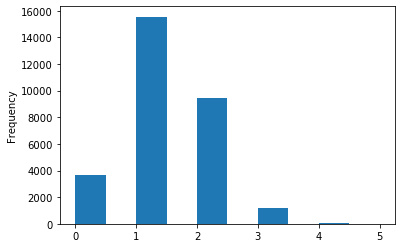

In [27]:
final.bed.plot.hist()

In [28]:
final['Property Type'].unique()

array([' Apartment ', ' Townhouse '], dtype=object)

In [29]:
final['Days on Market'].replace(regex=True, to_replace=r'\D', value='', inplace=True)
final[final['Days on Market'] == ''] = 0
final['Days on Market'] = pd.to_numeric(final['Days on Market'], errors='coerce')
final['Days on Market'] = final['Days on Market'].astype(int, errors='ignore')

final['Year Built'].replace(regex=True, to_replace=r'\D', value='', inplace=True)
final[final['Year Built'] == ''] = 0
final['Year Built'] = pd.to_numeric(final['Year Built'], errors='coerce')
final['Year Built'] = final['Year Built'].astype(int, errors='ignore')

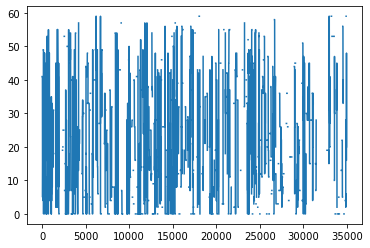

In [30]:
final['Days on Market'].plot()

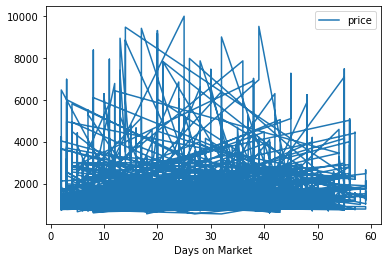

In [32]:
final[final['Year Built'] > 0]

,Heating,Days on Market,Year Built,Property Type,Microwave,Air Conditioning,Hot Tub or Spa,Balcony,Parking,Pool,Cats,dogs allowed,Fitness Center,Additional Storage,Dishwasher,Disposal,Dryer,Laundry Facilities,Washer,Window Coverings,Disabled Access,Gated Entry,Patio,Assigned Parking Space,Ceiling Fan,Garage,Refrigerator,Barbeque Area,Garden,Sprinkler System,Off Street,Security System,Views,Fireplace,Deck,Sauna,Electric,HOA Fee,Lawn,Other,Elevator,Basketball Court,Tennis Court,Garage Detached,Lot Size,Furnished,Gas,Vaulted Ceiling,Cats allowed,Sport Court,Skylight,Double Paned Windows,Intercom,Handrails,On Street,Dogs allowed,See Virtual Tour,Propane Butane,Wet Bar,Dock,Waterfront,None,Porch,Pond,Solar,Doorman,Forced Air,Rv Parking,price,sqft,bed,bath,zipcode,details
1,Other,41,2009,Apartment,True,True,True,True,None,True,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1127,753,1,1,89166,"{'Heating': ' Other ', 'Days on Market': ' 41 ..."
2,Other,41,2009,Apartment,True,True,True,True,None,True,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1124,771,1,1,89166,"{'Heating': ' Other ', 'Days on Market': ' 41 ..."
3,Other,41,2009,Apartment,True,True,True,True,None,True,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1335,849,1,1,89166,"{'Heating': ' Other ', 'Days on Market': ' 41 ..."
4,Other,41,2009,Apartment,True,True,True,True,None,True,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1347,820,1,1,89166,"{'Heating': ' Other ', 'Days on Market': ' 41 ..."
5,Other,41,2009,Apartment,True,True,True,True,None,True,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1123,801,1,1,89166,"{'Heating': ' Other ', 'Days on Market': ' 41 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34949,Forced Air,16,1972,Apartment,True,NaN,NaN,NaN,None,NaN,True,True,NaN,NaN,True,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1350,840,2,2,78723,"{'Heating': ' Forced Air', 'Electric': 'True',..."
34950,Forced Air,16,1972,Apartment,True,NaN,NaN,NaN,None,NaN,True,True,NaN,NaN,True,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,840,2,2,78723,"{'Heating': ' Forced Air', 'Electric': 'True',..."
34951,Forced Air,16,1972,Apartment,True,NaN,NaN,NaN,None,NaN,True,True,NaN,NaN,True,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1350,840,2,2,78723,"{'Heating': ' Forced Air', 'Electric': 'True',..."


In [34]:
simple_model_features = ['price', 'Days on Market', 'Year Built', 'sqft', 'bed', 'bath', 'zipcode']

In [35]:
simple = pd.DataFrame(final, columns=simple_model_features)

In [36]:
simple.dtypes

price               int64
Days on Market    float64
Year Built        float64
sqft                int64
bed                 int64
bath                int64
zipcode             int64
dtype: object

In [37]:
# simple.to_csv("simple_model.csv")

In [38]:
from sklearn.preprocessing import MinMaxScaler

In [39]:
scaler=MinMaxScaler()

In [44]:
scaler.fit(simple)

MinMaxScaler()

In [45]:
scaler.transform(simple)

array([[0.1128693 , 0.69491525, 0.99455446, ..., 0.2       , 0.02222222,
        0.99980938],
       [0.11256885, 0.69491525, 0.99455446, ..., 0.2       , 0.02222222,
        0.99980938],
       [0.13370055, 0.69491525, 0.99455446, ..., 0.2       , 0.02222222,
        0.99980938],
       ...,
       [0.10265398, 0.81355932, 0.97178218, ..., 0.2       , 0.02222222,
        0.88248882],
       [0.09514271, 0.81355932, 0.97178218, ..., 0.2       , 0.02222222,
        0.88248882],
       [0.1120681 , 0.33898305,        nan, ..., 0.4       , 0.02222222,
        0.88251124]])

,price,Days on Market,Year Built,sqft,bed,bath,zipcode
1,1127,41,2009,753,1,1,89166
2,1124,41,2009,771,1,1,89166
3,1335,41,2009,849,1,1,89166
4,1347,41,2009,820,1,1,89166
5,1123,41,2009,801,1,1,89166
